# Load the CSV File

In [ ]:
# Install gdown if not already installed
!pip install gdown

# Import required libraries
import gdown
import pandas as pd

# Define the file ID and URL
file_id = "1E6INPviYkWjMe1CafRpxcSWsq8pQNlh1"
url = f"https://drive.google.com/uc?id={file_id}"

# Download the file
gdown.download(url, "Traffic_Counts.csv", quiet=False)

# Load the CSV into a pandas DataFrame
traffic_data = pd.read_csv("Traffic_Counts.csv")

# Display the first few rows to verify the data
traffic_data.head()

Downloading...
From: https://drive.google.com/uc?id=1E6INPviYkWjMe1CafRpxcSWsq8pQNlh1
To: /content/Traffic_Counts.csv
100%|██████████| 444k/444k [00:00<00:00, 41.7MB/s]


,X,Y,OBJECTID,LABEL,DAILYTOTVOL,DATE_YEAR,TYPE,PEAKHOUR,HEAVYVEHIC,AVGSPEEDKMPH,LOCATION,PEDESTRIANS,LTURN_CYCLIST,RTURN_CYCLIST,THROUGH_CYCLIST,RECEIVING_CYCLIST,TOTAL_CYCLIST
0,607414.2882,4.910830e+06,1,ADT-11149,11149.0,2017.0,TMC,6194.0,NaN,NaN,E Mapleview and Stunden,21.0,0.0,0.0,0.0,0.0,0.0
1,607361.2864,4.910842e+06,2,ADT-3047,3047.0,2017.0,TMC,1693.0,NaN,NaN,N Mapleview and Stunden,8.0,0.0,0.0,4.0,4.0,8.0
2,607324.4490,4.910799e+06,3,ADT-14756,14756.0,2017.0,TMC,8198.0,NaN,NaN,W Mapleview and Stunden,17.0,2.0,0.0,0.0,4.0,6.0
3,607378.0862,4.910791e+06,4,ADT-1276,1276.0,2017.0,TMC,709.0,NaN,NaN,S Mapleview and Stunden,13.0,4.0,0.0,2.0,4.0,10.0
4,603249.9775,4.917695e+06,5,ADT-14015,14015.0,2017.0,TMC,7786.0,NaN,NaN,E Bayfield and Cundles,143.0,0.0,1.0,3.0,1.0,5.0


# Data Cleaning

In [ ]:
# Drop columns with high missing values
columns_to_drop = [
    "HEAVYVEHIC", "AVGSPEEDKMPH", "PEDESTRIANS",
    "LTURN_CYCLIST", "RTURN_CYCLIST", "THROUGH_CYCLIST",
    "RECEIVING_CYCLIST", "TOTAL_CYCLIST"
]
cleaned_data = traffic_data.drop(columns=columns_to_drop)

# Impute minor missing values
cleaned_data["DATE_YEAR"].fillna(cleaned_data["DATE_YEAR"].mode()[0], inplace=True)
cleaned_data["PEAKHOUR"].fillna(cleaned_data["PEAKHOUR"].median(), inplace=True)

# Drop rows with missing values in critical fields
critical_columns = ["LABEL", "DAILYTOTVOL"]
cleaned_data.dropna(subset=critical_columns, inplace=True)

# Rename columns for readability
cleaned_data.rename(columns={
    "DAILYTOTVOL": "DailyTrafficVolume",
    "PEAKHOUR": "PeakHourTraffic",
    "DATE_YEAR": "Year",
    "LOCATION": "Location"
}, inplace=True)

cleaned_data.head()

<ipython-input-2-e2881d374d43>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cleaned_data["DATE_YEAR"].fillna(cleaned_data["DATE_YEAR"].mode()[0], inplace=True)
<ipython-input-2-e2881d374d43>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].met

,X,Y,OBJECTID,LABEL,DailyTrafficVolume,Year,TYPE,PeakHourTraffic,Location
0,607414.2882,4.910830e+06,1,ADT-11149,11149.0,2017.0,TMC,6194.0,E Mapleview and Stunden
1,607361.2864,4.910842e+06,2,ADT-3047,3047.0,2017.0,TMC,1693.0,N Mapleview and Stunden
2,607324.4490,4.910799e+06,3,ADT-14756,14756.0,2017.0,TMC,8198.0,W Mapleview and Stunden
3,607378.0862,4.910791e+06,4,ADT-1276,1276.0,2017.0,TMC,709.0,S Mapleview and Stunden
4,603249.9775,4.917695e+06,5,ADT-14015,14015.0,2017.0,TMC,7786.0,E Bayfield and Cundles


# Save data to Aws RDS postgres db

/bin/bash: line 1: psql: command not found


In [ ]:
from sqlalchemy import create_engine
import pandas as pd

# Replace with your PostgreSQL credentials
DATABASE_TYPE = 'postgresql'
DBAPI = 'psycopg2'
HOST = 'database-city-of-barrie-traffic.c3cygy42s6pf.us-east-1.rds.amazonaws.com'
USER = 'postgres'
PASSWORD = 'Pass123$'
DATABASE = 'postgres'
PORT = 5432

# Create database connection URL
connection_url = f"{DATABASE_TYPE}+{DBAPI}://{USER}:{PASSWORD}@{HOST}:{PORT}/{DATABASE}"

# Create SQLAlchemy engine
engine = create_engine(connection_url)

# Write cleaned data to the database
cleaned_data.to_sql('traffic_data', engine, if_exists='replace', index=False)
print("Data successfully written to the cloud database!")

Data successfully written to the cloud database!


### Verify the Data

In [ ]:
import pandas as pd

# Query the data from the database
query = "SELECT * FROM traffic_data LIMIT 5;"
df = pd.read_sql(query, engine)
print(df)

             X             Y  OBJECTID      LABEL  DailyTrafficVolume    Year  \
0  607414.2882  4.910830e+06         1  ADT-11149             11149.0  2017.0   
1  607361.2864  4.910842e+06         2   ADT-3047              3047.0  2017.0   
2  607324.4490  4.910799e+06         3  ADT-14756             14756.0  2017.0   
3  607378.0862  4.910791e+06         4   ADT-1276              1276.0  2017.0   
4  603249.9775  4.917695e+06         5  ADT-14015             14015.0  2017.0   

  TYPE  PeakHourTraffic                 Location  
0  TMC           6194.0  E Mapleview and Stunden  
1  TMC           1693.0  N Mapleview and Stunden  
2  TMC           8198.0  W Mapleview and Stunden  
3  TMC            709.0  S Mapleview and Stunden  
4  TMC           7786.0   E Bayfield and Cundles  


### SQL queries to analyze the RDS data further.

In [ ]:
import pandas as pd
# 1. Count Total Records
query_1 = """
SELECT COUNT(*) AS total_records
FROM traffic_data;
"""
result_1 = pd.read_sql(query_1, engine)
print("Total Records:")
print(result_1)

# 2. Traffic Volume by Year
query_2 = """
SELECT "Year", SUM("DailyTrafficVolume") AS total_traffic_volume
FROM traffic_data
GROUP BY "Year"
ORDER BY "Year" ASC;
"""
result_2 = pd.read_sql(query_2, engine)
print("\nTraffic Volume by Year:")
print(result_2)

# 3. Top 10 Locations with Highest Traffic Volume
query_3 = """
SELECT "Location", SUM("DailyTrafficVolume") AS total_traffic_volume
FROM traffic_data
GROUP BY "Location"
ORDER BY total_traffic_volume DESC
LIMIT 10;
"""
result_3 = pd.read_sql(query_3, engine)
print("\nTop 10 Locations with Highest Traffic Volume:")
print(result_3)

# 4. Peak Hour Traffic Distribution
query_4 = """
SELECT
    CASE
        WHEN "PeakHourTraffic" <= 5000 THEN '0-5k'
        WHEN "PeakHourTraffic" <= 10000 THEN '5k-10k'
        WHEN "PeakHourTraffic" <= 15000 THEN '10k-15k'
        WHEN "PeakHourTraffic" <= 20000 THEN '15k-20k'
        ELSE '20k+'
    END AS traffic_range,
    COUNT(*) AS number_of_locations
FROM traffic_data
GROUP BY traffic_range
ORDER BY traffic_range;
"""
result_4 = pd.read_sql(query_4, engine)
print("\nPeak Hour Traffic Distribution:")
print(result_4)

# 5. Average Traffic Volume by Year
query_5 = """
SELECT "Year", AVG("DailyTrafficVolume") AS average_traffic_volume
FROM traffic_data
GROUP BY "Year"
ORDER BY "Year" ASC;
"""
result_5 = pd.read_sql(query_5, engine)
print("\nAverage Traffic Volume by Year:")
print(result_5)

# 6. Locations with Missing Data
query_6 = """
SELECT *
FROM traffic_data
WHERE "DailyTrafficVolume" IS NULL OR "PeakHourTraffic" IS NULL;
"""
result_6 = pd.read_sql(query_6, engine)
print("\nLocations with Missing Data:")
print(result_6)

# 7. Top 5 Years with the Highest Traffic Volume
query_7 = """
SELECT "Year", SUM("DailyTrafficVolume") AS total_traffic_volume
FROM traffic_data
GROUP BY "Year"
ORDER BY total_traffic_volume DESC
LIMIT 5;
"""
result_7 = pd.read_sql(query_7, engine)
print("\nTop 5 Years with the Highest Traffic Volume:")
print(result_7)


Total Records:
   total_records
0           4979

Traffic Volume by Year:
      Year  total_traffic_volume
0   2000.0              952201.0
1   2001.0              923673.0
2   2002.0             1183683.0
3   2003.0             1276789.0
4   2004.0             1640384.0
5   2005.0             1441881.0
6   2006.0             1498455.0
7   2007.0              309926.0
8   2008.0             1189295.0
9   2009.0               50042.0
10  2010.0             4402146.0
11  2011.0             4078969.0
12  2012.0             4196154.0
13  2013.0             8003188.0
14  2014.0             4547026.0
15  2017.0             6058439.0
16  2018.0             2249861.0
17  2019.0             1421342.0
18  2020.0             1478206.0
19  2021.0              544085.0

Top 10 Locations with Highest Traffic Volume:
                                            Location  total_traffic_volume
0                                               None            31168654.0
1                         Bayfield S

# Exploratory Data Analysis (EDA)

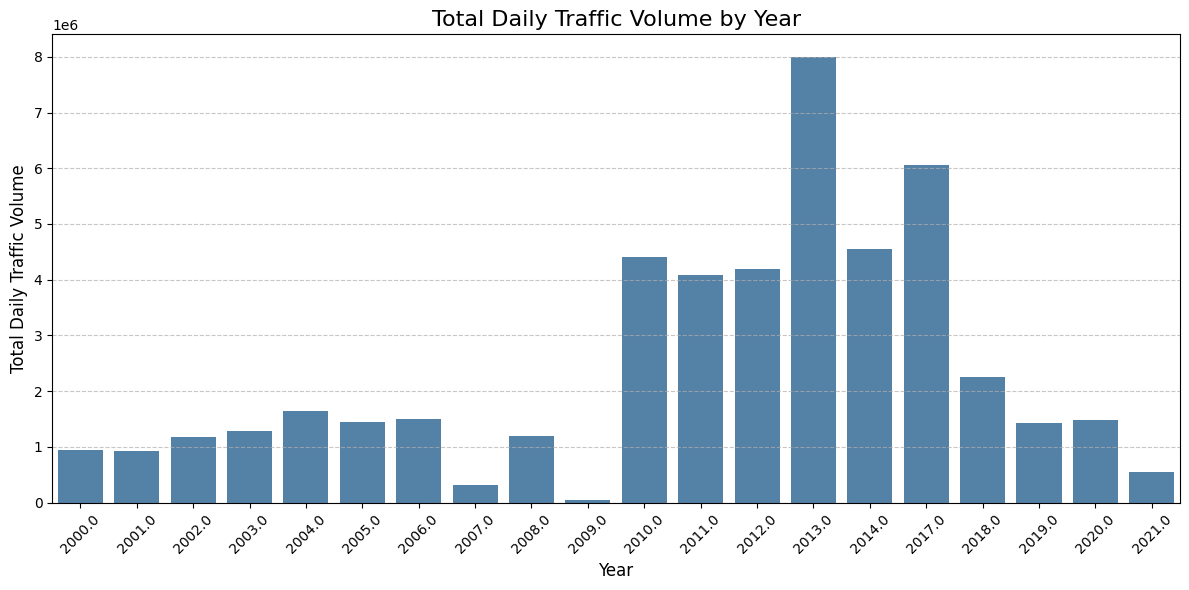

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate the data by Year
aggregated_data = cleaned_data.groupby('Year', as_index=False)['DailyTrafficVolume'].sum()

# Plot the total daily traffic volume by year
plt.figure(figsize=(12, 6))
sns.barplot(
    x='Year',
    y='DailyTrafficVolume',
    data=aggregated_data,
    color="steelblue",  # Use a single color to avoid the palette issue
    errorbar=None       # Replace the deprecated ci=None
)

# Enhance the graph for better clarity
plt.title('Total Daily Traffic Volume by Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Daily Traffic Volume', fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines to y-axis
plt.tight_layout()  # Adjust layout for better spacing

# Show the improved graph
plt.show()

# Visualizations

### Peak Hour Traffic Distribution:

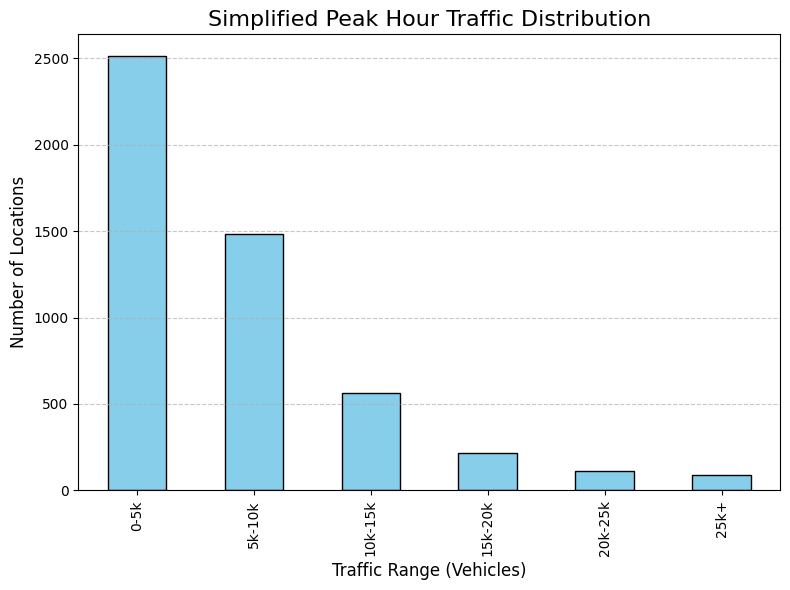

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Create broad ranges for PeakHourTraffic
bins = [0, 5000, 10000, 15000, 20000, 25000, 50000]  # Define ranges
labels = ['0-5k', '5k-10k', '10k-15k', '15k-20k', '20k-25k', '25k+']

# Create a new column for these ranges
cleaned_data['TrafficRange'] = pd.cut(cleaned_data['PeakHourTraffic'], bins=bins, labels=labels, include_lowest=True)

# Count locations in each range
range_counts = cleaned_data['TrafficRange'].value_counts().sort_index()

# Plot as a bar chart
plt.figure(figsize=(8, 6))
range_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Add titles and labels
plt.title('Simplified Peak Hour Traffic Distribution', fontsize=16)
plt.xlabel('Traffic Range (Vehicles)', fontsize=12)
plt.ylabel('Number of Locations', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

### Traffic Volume by Location (Top 10)

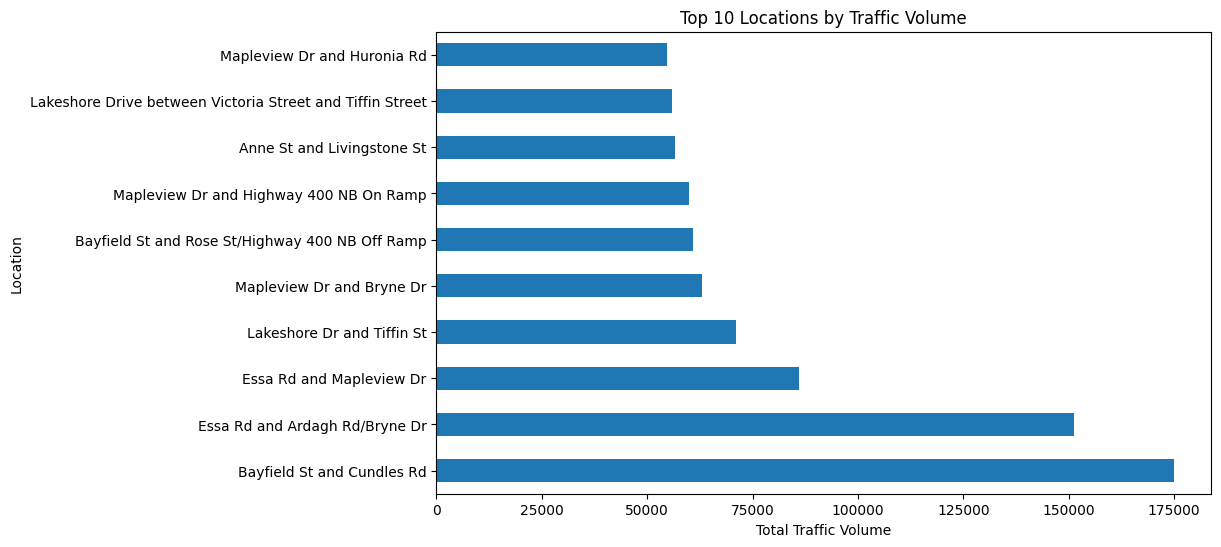

In [ ]:
top_locations = cleaned_data.groupby('Location')['DailyTrafficVolume'].sum().nlargest(10)
top_locations.plot(kind='barh', figsize=(10, 6))
plt.title('Top 10 Locations by Traffic Volume')
plt.xlabel('Total Traffic Volume')
plt.ylabel('Location')
plt.show()

# Save Outputs

In [ ]:
from google.colab import files
cleaned_data.to_csv('Cleaned_Traffic_Data.csv', index=False)
files.download('Cleaned_Traffic_Data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
plt.savefig('traffic_volume_by_year.png')
files.download('traffic_volume_by_year.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>

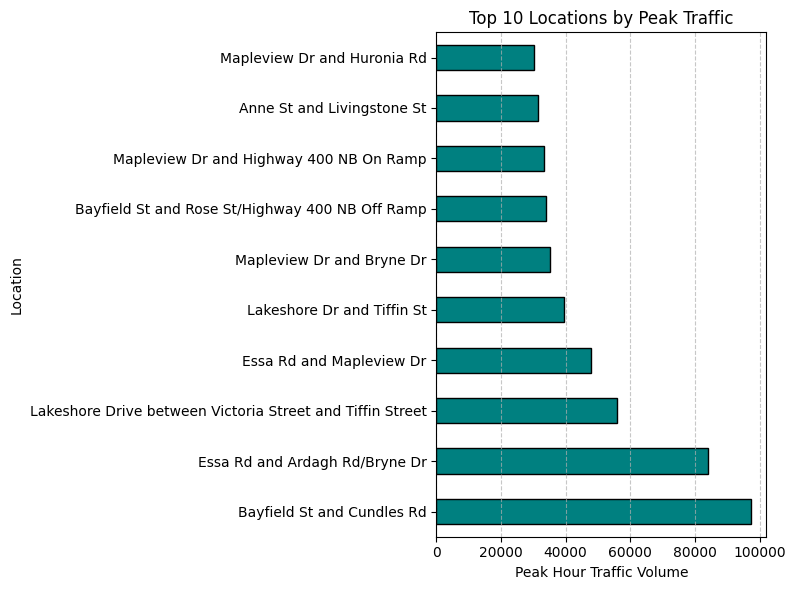

In [ ]:
top_locations = cleaned_data.groupby('Location')['PeakHourTraffic'].sum().nlargest(10)
top_locations.plot(kind='barh', figsize=(8, 6), color='teal', edgecolor='black')
plt.title('Top 10 Locations by Peak Traffic')
plt.xlabel('Peak Hour Traffic Volume')
plt.ylabel('Location')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()